# NI-VSM HW 4

Tým:

- Bittner Jan
- Bodnárová Radka
- Hošková Radka

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.stats as st
import matplotlib as mpl
import random

from scipy.optimize import curve_fit
from scipy.stats import poisson

## Popis problému

Uvažujte model hromadné obsluhy $M|G|\infty$. 

* Požadavky přichází podle Poissonova procesu s intenzitou $\lambda = 10~\mathrm{s}^{-1}$.
* Doba obsluhy jednoho požadavku (v sekundách) má rozdělení $S\sim\mathrm{Ga}(4,2)$, tj. Gamma s parametry $a = 4$, $p = 2.$
* Časy mezi příchody a časy obsluhy jsou nezávislé.
* Systém má (teoreticky) nekonečně paralelních obslužných míst (každý příchozí je rovnou obsluhován).

Označme $N_t$ počet zákazníků v systému v čase $t$. Předpokládejme, že na začátku je systém prázdný, tj. $N_0 = 0$.

## 1 - Simulujte jednu trajektorii $\{N_t(\omega) \mid t\in(0,10~\mathrm{s})\}$. Průběh trajektorie graficky znázorněte.

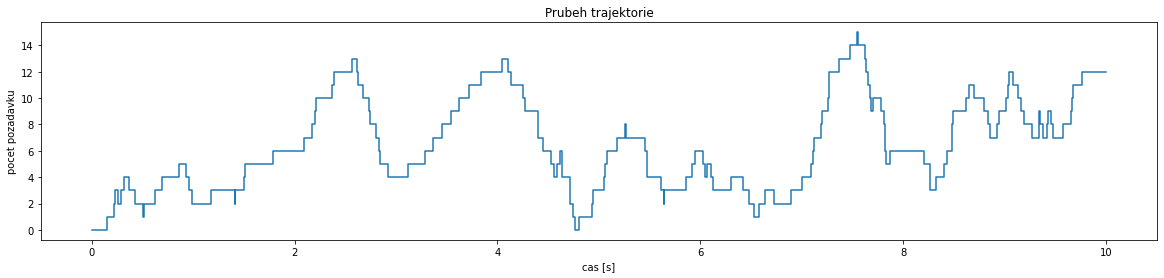

In [2]:
l = 10  # lambda
t = 10  # time max
a = 4   # skalovani
p = 2   # tvar

def simulate_trajectory(intensity, t_max, shape, scale):
    # pocet pozadavku za zadany cas je vygenerovan pomoci poissonova rozdeleni
    request_count = np.random.poisson(intensity * t_max)

    # ziskany pocet pozadavku je rozlozen pomoci uniformniho rozdeleni
    incomming_req = np.random.uniform(low=0, high=t_max, size=request_count)
    T = np.sort(incomming_req)

    # doby obsluhy pozadavku jsou vygenerovany pomoci gamma rozdeleni
    wait_time = np.random.gamma(shape, 1/scale, size=request_count)
    T_leave = T + wait_time

    # iterace pres jednotlive casy
    counter_enter = 0
    counter_leave = 0
    i = 0
    N = [0]
    while True:
        # ukonceni cyklu
        if counter_enter >= request_count:
            break
        if counter_leave >= request_count:
            break

        if counter_enter >= request_count or T_leave[counter_leave] < T[counter_enter]:
            if T_leave[counter_leave] > t_max:
                break
            i -= 1
            counter_leave += 1
        else:
            i += 1
            counter_enter += 1

        N.append(i)
    
    T = np.sort(np.append(T, T_leave))
    T = np.append([0], T)
    T = T[:len(N)]
    T = np.append(T, t_max)
    N = np.append(N, N[-1])

    return T, N, N[-1]

T, N, N_10 = simulate_trajectory(l, t, p, a)

plt.figure(figsize=(20,4))
plt.step(T, N, where='post')
plt.title("Prubeh trajektorie")
plt.xlabel('cas [s]')
plt.ylabel('pocet pozadavku')
plt.show()

## 2 - Simulujte $n = 500$ nezávislých trajektorií pro $t\in(0,100)$. Na základě těchto simulací odhadněte rozdělení náhodné veličiny $N_{100}$.

($N_t$ - počet zákazníků v systému v čase $t$)

9.514 24.185804


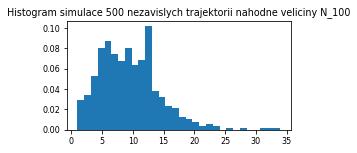

gamma[0.0016631335037555592, (4.28233880262632,), -0.6212334014757503, 2.366749960634369]
t[0.0028482468366281804, (23297.931531056623,), 9.51369048008375, 4.917433604899043]
norm[0.002848509061224648, (), 9.514, 4.917906465153643]
expon[0.009062751598462102, (), 1.0, 8.514]
uniform[0.014140275482093666, (), 1.0, 33.0]


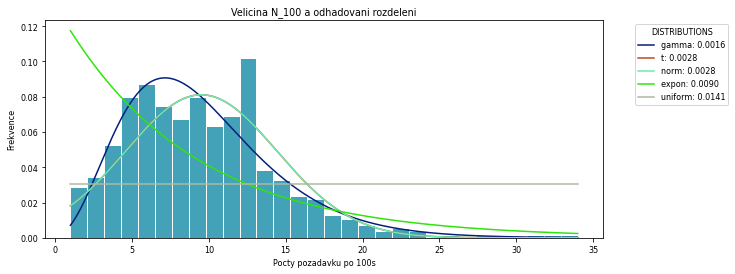

Text(0.5, 1.0, 'Velicina N_100 prolozena Poissonovym rozdelenim')

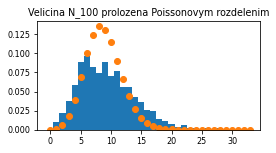

In [3]:
mpl.rcParams.update({'font.size': 8})
plt.figure(figsize=(4,2))
n = 500
N_100 = [simulate_trajectory(10, 100, p, a)[2] for i in range(n)]

print(np.mean(N_100), np.var(N_100))

counts, bins = np.histogram(N_100, density="True", bins=30)
plt.hist(bins[:-1], bins, weights=counts, density=True)
plt.title("Histogram simulace 500 nezavislych trajektorii nahodne veliciny N_100")
plt.show()





# edited: https://stackoverflow.com/a/66219519/13156298

def danoes_formula(data):
    """
    DANOE'S FORMULA
    https://en.wikipedia.org/wiki/Histogram#Doane's_formula
    """
    N = len(data)
    skewness = st.skew(data)
    sigma_g1 = math.sqrt((6*(N-2))/((N+1)*(N+3)))
    num_bins = 1 + math.log(N,2) + math.log(1+abs(skewness)/sigma_g1,2)
    num_bins = round(num_bins)
    return num_bins

def plot_histogram(data, results, n):
    ## n first distribution of the ranking
    N_DISTRIBUTIONS = {k: results[k] for k in list(results)[:n]}

    ## Histogram of data
    plt.figure(figsize=(10, 4))
    plt.hist(data, density=True, ec='white', color=(63/235, 149/235, 170/235), bins=30)
    plt.title('Velicina N_100 a odhadovani rozdeleni')
    plt.xlabel('Pocty pozadavku po 100s')
    plt.ylabel('Frekvence')

    ## Plot n distributions
    for distribution, result in N_DISTRIBUTIONS.items():
        # print(i, distribution)
        sse = result[0]
        arg = result[1]
        loc = result[2]
        scale = result[3]
        x_plot = np.linspace(min(data), max(data), 1000)
        y_plot = distribution.pdf(x_plot, loc=loc, scale=scale, *arg)
        plt.plot(x_plot, y_plot, label=str(distribution).split('.')[-1].split(' ')[0].split('_')[0] + ": " + str(sse)[0:6], 
                 color=(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)))
        print(str(distribution).split('.')[-1].split(' ')[0].split('_')[0] + str(result))

    plt.legend(title='DISTRIBUTIONS', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

def fit_data(data):
    ## st.frechet_r,st.frechet_l: are disbled in current SciPy version
    ## st.levy_stable: a lot of time of estimation parameters

    # MY_DISTRIBUTIONS = [ st.expon, st.norm, st.gamma]
    MY_DISTRIBUTIONS = [st.gamma, st.expon, st.norm, st.uniform, st.t]

    ## Calculae Histogram
    num_bins = danoes_formula(data)
    frequencies, bin_edges = np.histogram(data, num_bins, density=True)
    central_values = [(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]

    results = {}
    for distribution in MY_DISTRIBUTIONS:
        ## Get parameters of distribution
        params = distribution.fit(data)
        
        ## Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]
    
        ## Calculate fitted PDF and error with fit in distribution
        pdf_values = [distribution.pdf(c, loc=loc, scale=scale, *arg) for c in central_values]
        
        ## Calculate SSE (sum of squared estimate of errors)
        sse = np.sum(np.power(frequencies - pdf_values, 2.0))
        
        ## Build results and sort by sse
        results[distribution] = [sse, arg, loc, scale]
        
    results = {k: results[k] for k in sorted(results, key=results.get)}
    return results

results = fit_data(N_100)
plot_histogram(N_100, results, 20)

# https://stackoverflow.com/a/25828558/13156298
plt.figure(figsize=(4,2))
bins = np.arange(30) - 0.5
entries, bin_edges, patches = plt.hist(N_100, bins=bins, density=True, label='Data')
bin_middles = 0.5 * (bin_edges[1:] + bin_edges[:-1]) # calculate bin centres
def fit_function(k, lamb):
    # poisson function, parameter lamb is the fit parameter
    return poisson.pmf(k, lamb)

parameters, cov_matrix = curve_fit(fit_function, bin_middles, entries) # fit with curve_fit
x_plot = np.arange(0, max(N_100)) # plot poisson-deviation with fitted parameter
plt.plot(x_plot,fit_function(x_plot, *parameters), marker='o', linestyle='', label='Fit result')
plt.title("Velicina N_100 prolozena Poissonovym rozdelenim")

Simulovali jsme 500 nezávislých trajektorií pro $t\in(0,100)$. Podle kodu fitovani distribuce se rozdeleni nejvice podoba )gamma) rozdeleni, _studentovo t rozdeleni_ a _normalni rozdeleni_. Bohuzel poissonovo rozdeleni nema `fit` funkci, proto bylo vizualizovano zvlast. 

Nejvice vsak odpovida gamma rozdeleni.

## 3 - Diskutujte, jaké je limitní rozdělení tohoto systému pro $t\to+\infty$. Pomocí vhodného testu otestujte na hladině významnosti $5~\%$, zda výsledky simulace $N_{100}$ odpovídají tomuto rozdělení.

Dle prednasky (23., slide 21) ma pocet zakazniku(pozadavku) v systemu M|G|∞ z dlouhodobeho hlediska (t→+∞) Poissonovo rozdeleni s intenzitou $\lambda/\mu$. 

$\lambda$=10

$\mu$= EX = p/a = 4/2 = 2

$\lambda$/$\mu$ = 10/2 = 5

$H_0$: $N_t∼\text{Poisson}(5)$ pro $(t\to+\infty)$

$H_A$: $N_t$ ma v $(t\to+\infty)$ jine rozdeleni.

In [4]:
def poisson(l, k):
    return ((l**k) * (math.e**-l)) / math.factorial(k)

expected = [poisson(5, k) for k in range(len(counts))]
print(counts)
print(expected)

st.chisquare(counts, expected)

chi2, pvalue = st.chisquare(counts, expected)
test_alpha = 0.05

print(f'test statistic χ² = {chi2:.4g}')
print(f'p-value = {pvalue:.4g}')
print(f'{pvalue > test_alpha}')

[0.02909091 0.03454545 0.05272727 0.08       0.08727273 0.07454545
 0.06727273 0.08       0.06363636 0.06909091 0.10181818 0.03818182
 0.03272727 0.02363636 0.02181818 0.01272727 0.01090909 0.00727273
 0.00363636 0.00545455 0.00363636 0.         0.00181818 0.
 0.00181818 0.         0.         0.00181818 0.00181818 0.00181818]
[0.006737946999085469, 0.033689734995427344, 0.08422433748856836, 0.14037389581428059, 0.17546736976785074, 0.17546736976785074, 0.14622280813987562, 0.10444486295705402, 0.06527803934815876, 0.036265577415643756, 0.018132788707821874, 0.008242176685373581, 0.003434240285572325, 0.0013208616482970482, 0.0004717363029632315, 0.00015724543432107718, 4.9139198225336615e-05, 1.4452705360393122e-05, 4.014640377886979e-06, 1.0564843099702575e-06, 2.641210774925643e-07, 6.288597083156294e-08, 1.4292266098082488e-08, 3.1070143691483665e-09, 6.472946602392431e-10, 1.2945893204784861e-10, 2.4895948470740117e-11, 4.610360827914837e-12, 8.232787192705065e-13, 1.41944606770777

Na zaklade $p$-value zamítáme hypotezu $H_0$ ve prospěch alternativní hypotézy $H_A$.